## Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime
from tqdm import tqdm
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
# Training and Testing directories
training_dir = os.path.join("Datasets", "Training")
testing_dir = os.path.join("Datasets", "Testing")
if not os.path.isdir(training_dir):
    raise Exception("ERROR: training dataset not found")
if not os.path.isdir(testing_dir):
    raise Exception("ERROR: testing dataset not found")

In [3]:
# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        print(os.path.join(root, file))

Datasets/Training/tweets_#nfl.txt
Datasets/Training/tweets_#superbowl.txt
Datasets/Training/tweets_#sb49.txt
Datasets/Training/tweets_#patriots.txt
Datasets/Training/tweets_#gohawks.txt
Datasets/Training/tweets_#gopatriots.txt


In [4]:
# Initialize dictionaries and Unix times for Feb 1, 8 am and Feb 1, 8 pm. 
# Dictionary keys: hashtag.
# Dictionary values: [time of tweet (Unix), number of retweets for tweet, number of followers for tweeter]
# Each row in dictionary value is an individual tweet.

hashtag_dict_before = {}
hashtag_dict_during = {}
hashtag_dict_after = {}
start_unix_time = 1422806400 # 8 am, Feb 1, PST
end_unix_time = 1422849600 # 8 pm, Feb 1, PST
pst_tz = pytz.timezone('America/Los_Angeles')


In [5]:
""" Parse files to get necessary data """

for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
        print('Parsing {}...'.format(filename))
        
        hashtag_dict_before[filename] = []
        hashtag_dict_during[filename] = []
        hashtag_dict_after[filename] = []
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in hashtag:
                json_obj = json.loads(line)
                
                # get desired statistics
                citation_date = json_obj['citation_date'] # Unix time
                num_retweets = json_obj['metrics']['citations']['total'] # Number of retweets for this tweet
                num_followers = json_obj['author']['followers'] # Number of followers for tweeter
                
                # Check when tweet was made and add it to corresponding dictionary
                if citation_date < start_unix_time:
                    hashtag_dict_before[filename].append([citation_date, num_retweets, num_followers])
                elif citation_date > end_unix_time:
                    hashtag_dict_after[filename].append([citation_date, num_retweets, num_followers])
                else:
                    hashtag_dict_during[filename].append([citation_date, num_retweets, num_followers])
    print('done')

Parsing nfl...
Parsing superbowl...
Parsing sb49...
Parsing patriots...
Parsing gohawks...
Parsing gopatriots...
done


## Organize Data

##### Variables:
<span>
key = one of the hashtags <br \> <br \>
</span>

<span>
data_hashtag_before[key] = data before 2/1 8am, split into 1-hour windows (separated by hashtag) <br \>
data_hashtag_during[key] = data between 2/1 8am and 8pm, split into 5-min windows (separated by hashtag) <br \>
data_hashtag_after[key] = data after 2/1 8pm, split into 1-hour windows (separated by hashtag) <br \> <br \>
</span>

<span>
data_aggregate_before = data before 2/1 8am, split into 1-hour windows (all hashtags combined) <br \>
data_aggregate_during = data between 2/1 8am and 8pm, split into 5-min windows (all hashtags combined) <br \>
data_aggregate_after = data after 2/1 8pm, split into 1-hour windows (all hashtags combined) <br \> <br \>
</span>

<span>
data_hashtag_all[key] = all data, split into 1-hour windows (separated by hashtag) <br \> <br \>
</span>

<span>
data_all = all data, split into 1-hour windows (all hashtags combined) <br \>
</span>

In [6]:
# Explicitly list hashtags. 
# Convert each value in dictionary to numpy arrays.

hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']

for key in hashtags:
    hashtag_dict_before[key] = np.array(hashtag_dict_before[key])
    hashtag_dict_during[key] = np.array(hashtag_dict_during[key])
    hashtag_dict_after[key] = np.array(hashtag_dict_after[key])

In [7]:
# Find how many time windows there are

ftt = int(np.min([np.min(hashtag_dict_before[key][:,0]) for key in hashtags])) # first tweet time
ltt = int(np.max([np.max(hashtag_dict_after[key][:,0]) for key in hashtags])) # last tweet time

num_windows_before = int(np.max([((start_unix_time - ftt) // 3600) + 1 for key in hashtags]))
num_windows_during = int(np.max([((end_unix_time - start_unix_time) // 3600 * 12) for key in hashtags]))
num_windows_after = int(np.max([((ltt - end_unix_time) // 3600) + 1 for key in hashtags]))


In [8]:
""" Organize data into specific time periods:
     before 2/1 8am with 1-hour windows, 
     between 2/1 8am and 2/1 8pm with 5-min windows,
     and after 2/1 8pm with 1-hour windows """

# Initialize dictionary for each time frame.
data_hashtag_before = {}
data_hashtag_during = {}
data_hashtag_after = {}

# Iterate through each hashtag.
for key in hashtags:
    print(key)
    
    # Rename the dictionary value for readability
    temp_before = hashtag_dict_before[key]
    temp_during = hashtag_dict_during[key]
    temp_after = hashtag_dict_after[key]
    
    data_hashtag_before[key] = np.zeros((num_windows_before, 5)) # Initialize array: rows = time window, columns = feature
    num_followers_before = {} # Initialize dictionary to count # of followers for each tweet
    
    
    
    # Iterate through all elements before start time
    for i in range(np.shape(temp_before)[0]):
        # Get row number
        item_before = int(num_windows_before - 1 - ((start_unix_time - temp_before[i,0] - 1) // 3600))
        # Update first 3 elements (# of tweets, total # retweets, total # followers)
        data_hashtag_before[key][item_before] += np.array([1, int(temp_before[i, 1]), int(temp_before[i, 2]), 0, 0])
        # Get time of day (hour)
        dt_obj_pst = datetime.fromtimestamp(temp_before[i,0], pst_tz)
        data_hashtag_before[key][item_before][4] = int(datetime.strftime(dt_obj_pst, '%H'))
        # Get number of followers
        if item_before not in num_followers_before.keys():
            num_followers_before[item_before] = []
        num_followers_before[item_before].append(temp_before[i,2])
    for i in num_followers_before.keys():
        data_hashtag_before[key][i][3] = np.max(num_followers_before[i])
        
        
    # Iterate through all elements during time
    data_hashtag_during[key] = np.zeros((num_windows_during, 5))
    num_followers_during = {}
    for i in range(np.shape(temp_during)[0]):
        item_during = int(((temp_during[i,0] - start_unix_time) * 12) // 3600)
        data_hashtag_during[key][item_during] += np.array([1, int(temp_during[i, 1]), int(temp_during[i, 2]), 0, 0])
        dt_obj_pst = datetime.fromtimestamp(temp_during[i,0], pst_tz)
        data_hashtag_during[key][item_during][4] = int(datetime.strftime(dt_obj_pst, '%H'))
        
        if item_during not in num_followers_during.keys():
            num_followers_during[item_during] = []
        num_followers_during[item_during].append(temp_during[i,2])
    for i in num_followers_during.keys():
        data_hashtag_during[key][i][3] = np.max(num_followers_during[i])
        
    # Iterate through all elements after end time
    data_hashtag_after[key] = np.zeros((num_windows_after, 5))
    num_followers_after = {}
    for i in range(np.shape(temp_after)[0]):
        item_after = int((temp_after[i,0] - end_unix_time) // 3600)
        data_hashtag_after[key][item_after] += np.array([1, int(temp_after[i, 1]), int(temp_after[i, 2]), 0, 0])
        dt_obj_pst = datetime.fromtimestamp(temp_after[i,0], pst_tz)
        data_hashtag_after[key][item_after][4] = int(datetime.strftime(dt_obj_pst, '%H'))
        
        if item_after not in num_followers_after.keys():
            num_followers_after[item_after] = []
        num_followers_after[item_after].append(temp_after[i,2])
    for i in num_followers_after.keys():
        data_hashtag_after[key][i][3] = np.max(num_followers_after[i])
        
print('done')

gohawks
gopatriots
nfl
patriots
sb49
superbowl
done


In [9]:
""" Aggregate data within each time period by combining all hashtags. """

# Initialize aggregated data variables
data_aggregate_before = np.zeros([num_windows_before, 5])
data_aggregate_during = np.zeros([num_windows_during, 5])
data_aggregate_after = np.zeros([num_windows_after, 5])

# Sum the # of tweets, total # of retweets, and # of followers
for key in hashtags:
    data_aggregate_before[:,0:3] += data_hashtag_before[key][:,0:3]
    data_aggregate_during[:,0:3] += data_hashtag_during[key][:,0:3]
    data_aggregate_after[:,0:3] += data_hashtag_after[key][:,0:3]
# Find the max # of followers for each
data_aggregate_before[:,3] = np.amax([data_hashtag_before[key][:,3] for key in hashtags], axis=0)
data_aggregate_during[:,3] = np.amax([data_hashtag_during[key][:,3] for key in hashtags], axis=0)
data_aggregate_after[:,3] = np.amax([data_hashtag_after[key][:,3] for key in hashtags], axis=0)

# Copy over the same time frames
data_aggregate_before[:,4] = data_hashtag_before['superbowl'][:,4]
data_aggregate_during[:,4] = data_hashtag_during['superbowl'][:,4]
data_aggregate_after[:,4] = data_hashtag_after['superbowl'][:,4]

In [10]:
""" Get data for the whole time frame with 1-hour windows, separated by hashtag """

# Initialize dictionary to store data.
# Key: hashtag
# Value: data separated by 1-hour time windows
data_hashtag_all = {}

for key in hashtags: # Iterate through all hashtags
    temp_during = np.zeros([12, 5]) # Initialize array to store data in the middle time period
    # Combine data in the middle time period
    for i in range(np.shape(data_hashtag_during[key])[0]):
        hour = int(data_hashtag_during[key][i,4] - 8)
        temp_during[hour, :3] += data_hashtag_during[key][i, :3]
        if not i % 12:
            temp_during[hour, 3] = np.max(data_hashtag_during[key][i:(i+12), 3])
            temp_during[hour, 4] = data_hashtag_during[key][i,4]
    data_hashtag_all[key] = np.vstack((data_hashtag_before[key], temp_during, data_hashtag_after[key]))

In [11]:
""" Combine data for the whole time frame from all hashtags """

data_all = np.zeros([587, 5])
for key in hashtags:
    data_all += data_hashtag_all[key]

In [12]:
data_hashtag_all['gohawks'].shape

(587, 5)

## Linear Regression

In [13]:
# Function to get MSE for a given linear regression model.

def analyze_lr(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    mse_test = mean_squared_error(y_test, predicted)
    mse_train = mean_squared_error(y_train, model.predict(X_train))
#     r2_test = r2_score(y_test, predicted) 
#     r2_train = r2_score(y_train, model.predict(X_train))
    print('MSE:\n   train = {} \n test = {}'.format(mse_train, mse_test))
#     print('R2 measure:\n   train = {} \n test = {}'.format(r2_train, r2_test))
    print('-------------')
    
    return mse_train, mse_test

In [15]:
# Analyze tweets before start time.

mses = []
mses_train = []
r2_test = []
r2_train = []

# Define train data and targets
for tagg in hashtags:
    y = data_hashtag_all[tagg][1:,0] # Number of tweets (except first)
    X = np.delete(data_hashtag_all[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    model = LinearRegression()
    mse_train , mse_test = analyze_lr(model, X, y)


Hashtag: gohawks
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 512854.09161298693 
 test = 1643083.6454898382
-------------
Hashtag: gopatriots
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 29130.353089517917 
 test = 38710.86492773072
-------------
Hashtag: nfl
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 216423.0911017843 
 test = 369706.1940656257
-------------
Hashtag: patriots
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 5960160.941102434 
 test = 6940065.266194089
-------------
Hashtag: sb49
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 24629712.20773327 
 test = 30924517.778785758
-------------
Hashtag: superbowl
X shape: (586, 5)
y shape: (586,)
MSE:
   train = 65690240.83719405 
 test = 64436708.78616054
-------------


In [16]:
# Analysis of feature significance

for tagg in hashtags:
    y = data_hashtag_all[tagg][1:,0] # Number of tweets (except first)
    X = np.delete(data_hashtag_all[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    print('---------------')


Hashtag: gohawks
X shape: (586, 5)
y shape: (586,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           4.31e-86
Time:                        18:38:31   Log-Likelihood:                -4795.4
No. Observations:                 586   AIC:                             9601.
Df Residuals:                     581   BIC:                             9623.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x

## Piece-wise Linear Regression

#### Question 6

In [17]:
# Define train data and targets
for tagg in hashtags:
    y1 = data_hashtag_before[tagg][1:,0] # Number of tweets (except first)
    X1 = np.delete(data_hashtag_before[tagg], -1, 0) # Delete last row
    y2 = data_hashtag_during[tagg][1:,0] # Number of tweets (except first)
    X2 = np.delete(data_hashtag_during[tagg], -1, 0) # Delete last row
    y3 = data_hashtag_after[tagg][1:,0] # Number of tweets (except first)
    X3 = np.delete(data_hashtag_after[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    model = LinearRegression()
    print('****Before****')
    mse_train , mse_test = analyze_lr(model, X1, y1)
    print('****During****')
    mse_train , mse_test = analyze_lr(model, X2, y2)
    print('****After****')
    mse_train , mse_test = analyze_lr(model, X3, y3)


Hashtag: gohawks
X shape: (586, 5)
y shape: (586,)
****Before****
MSE:
   train = 69706.01044834527 
 test = 3062922.2893514833
-------------
****During****
MSE:
   train = 84144.7693946039 
 test = 70632.31242527574
-------------
****After****
MSE:
   train = 1379.202418578555 
 test = 2749.4407660940706
-------------
Hashtag: gopatriots
X shape: (586, 5)
y shape: (586,)
****Before****
MSE:
   train = 74.4378523492514 
 test = 4745.15314596021
-------------
****During****
MSE:
   train = 12669.77215309922 
 test = 15320.43926706397
-------------
****After****
MSE:
   train = 11.413761440242457 
 test = 228.188431969641
-------------
Hashtag: nfl
X shape: (586, 5)
y shape: (586,)
****Before****
MSE:
   train = 16757.33756238002 
 test = 119770.73198032069
-------------
****During****
MSE:
   train = 17670.786470509647 
 test = 26874.11442263643
-------------
****After****
MSE:
   train = 18883.368826212016 
 test = 16940.79757793922
-------------
Hashtag: patriots
X shape: (586, 5)
y s

#### Question 7

In [18]:
y1 = data_aggregate_before[1:,0] # Number of tweets (except first)
X1 = np.delete(data_aggregate_before, -1, 0) # Delete last row
y2 = data_aggregate_during[1:,0] # Number of tweets (except first)
X2 = np.delete(data_aggregate_during, -1, 0) # Delete last row
y3 = data_aggregate_after[1:,0] # Number of tweets (except first)
X3 = np.delete(data_aggregate_after, -1, 0) # Delete last row
print('Hashtag: '+ tagg)
print('X shape:', X.shape)
print('y shape:', y.shape)
model = LinearRegression()
print('****Before****')
mse_train , mse_test = analyze_lr(model, X1, y1)
print('****During****')
mse_train , mse_test = analyze_lr(model, X2, y2)
print('****After****')
mse_train , mse_test = analyze_lr(model, X3, y3)


Hashtag: superbowl
X shape: (586, 5)
y shape: (586,)
****Before****
MSE:
   train = 892423.5377543266 
 test = 8339131.723993236
-------------
****During****
MSE:
   train = 18895720.778803244 
 test = 16714211.339941263
-------------
****After****
MSE:
   train = 296866.62104623887 
 test = 1654667.5995643556
-------------


## Feature Analysis

#### Question 4

""" Features used: 
1) Number of tweets
2) Total number of retweets
3) Sum of the number of followers of the user posting the hashtag
4) Maximum number of followers
5) Time of day
6)Influence
7) Number of replies
8) Impressions
9) Peak
10) Acceleration
11) If the user is verified or not





"""


In [22]:
""" Parse files to get necessary data """

for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
        print('Parsing {}...'.format(filename))
        
        hashtag_dict_before[filename] = []
        hashtag_dict_during[filename] = []
        hashtag_dict_after[filename] = []
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in hashtag:
                json_obj = json.loads(line)
                
                # get desired statistics
                citation_date = json_obj['citation_date'] # Unix time
                num_retweets = json_obj['metrics']['citations']['total'] # Number of retweets for this tweet
                num_followers = json_obj['author']['followers'] # Number of followers for tweeter
                # New features
                influence = json_obj['metrics']['citations']['influential'] # Influence level
                num_replies = json_obj['metrics']['citations']['replies'] #Number of replies
                impressions = json_obj['metrics']['impressions']
                peak = json_obj['metrics']['peak']
                acceleration = json_obj['metrics']['acceleration']
                verified = json_obj['tweet']['user']['verified']
                if verified == True:
                    verified1 = 1
                else:
                    verified1 = 0
#                 print(verified1)
                
                # Check when tweet was made and add it to corresponding dictionary
                if citation_date < start_unix_time:
                    hashtag_dict_before[filename].append([citation_date, num_retweets, num_followers, influence, num_replies, impressions, peak, acceleration, verified1])
                elif citation_date > end_unix_time:
                    hashtag_dict_after[filename].append([citation_date, num_retweets, num_followers, influence, num_replies, impressions, peak, acceleration, verified1])
                else:
                    hashtag_dict_during[filename].append([citation_date, num_retweets, num_followers, influence, num_replies, impressions, peak, acceleration, verified1])
    print('done')

Parsing nfl...
Parsing superbowl...
Parsing sb49...
Parsing patriots...
Parsing gohawks...
Parsing gopatriots...
done


In [25]:
# Explicitly list hashtags. 
# Convert each value in dictionary to numpy arrays.

hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']

for key in hashtags:
    hashtag_dict_before[key] = np.array(hashtag_dict_before[key])
    hashtag_dict_during[key] = np.array(hashtag_dict_during[key])
    hashtag_dict_after[key] = np.array(hashtag_dict_after[key])

In [26]:
# Find how many time windows there are

ftt = int(np.min([np.min(hashtag_dict_before[key][:,0]) for key in hashtags])) # first tweet time
ltt = int(np.max([np.max(hashtag_dict_after[key][:,0]) for key in hashtags])) # last tweet time

num_windows_before = int(np.max([((start_unix_time - ftt) // 3600) + 1 for key in hashtags]))
num_windows_during = int(np.max([((end_unix_time - start_unix_time) // 3600 * 12) for key in hashtags]))
num_windows_after = int(np.max([((ltt - end_unix_time) // 3600) + 1 for key in hashtags]))


In [47]:
""" Organize data into specific time periods:
     before 2/1 8am with 1-hour windows, 
     between 2/1 8am and 2/1 8pm with 5-min windows,
     and after 2/1 8pm with 1-hour windows """

# Initialize dictionary for each time frame.
data_hashtag_before = {}
data_hashtag_during = {}
data_hashtag_after = {}

# Iterate through each hashtag.
for key in hashtags:
    print(key)
    
    # Rename the dictionary value for readability
    temp_before = hashtag_dict_before[key]
    temp_during = hashtag_dict_during[key]
    temp_after = hashtag_dict_after[key]
#     print(temp_before.shape)
    
    data_hashtag_before[key] = np.zeros((num_windows_before, 11)) # Initialize array: rows = time window, columns = feature
    num_followers_before = {} # Initialize dictionary to count # of followers for each tweet
#     print(data_hashtag_before[key].shape)
    
    
    # Iterate through all elements before start time
    for i in range(np.shape(temp_before)[0]):
        # Get row number
        item_before = int(num_windows_before - 1 - ((start_unix_time - temp_before[i,0] - 1) // 3600))
        # Update first 3 elements (# of tweets, total # retweets, total # followers)
        data_hashtag_before[key][item_before] += np.array([1, int(temp_before[i, 1]), int(temp_before[i, 2]), 0, int(temp_before[i, 3]), int(temp_before[i, 4]), int(temp_before[i, 5]), int(temp_before[i, 6]), int(temp_before[i, 7]), int(temp_before[i, 8]), 0])
        # Get time of day (hour)
        dt_obj_pst = datetime.fromtimestamp(temp_before[i,0], pst_tz)
        data_hashtag_before[key][item_before][10] = int(datetime.strftime(dt_obj_pst, '%H'))
        # Get number of followers
        if item_before not in num_followers_before.keys():
            num_followers_before[item_before] = []
        num_followers_before[item_before].append(temp_before[i,2])
    for i in num_followers_before.keys():
        data_hashtag_before[key][i][3] = np.max(num_followers_before[i])
        
        
    # Iterate through all elements during time
    data_hashtag_during[key] = np.zeros((num_windows_during, 11))
    num_followers_during = {}
    print(np.shape(temp_during)[0])
    for i in range(np.shape(temp_during)[0]):
        item_during = int(((temp_during[i,0] - start_unix_time) * 12) // 3600)
        data_hashtag_during[key][item_during] += np.array([1, int(temp_during[i, 1]), int(temp_during[i, 2]), 0, int(temp_during[i, 3]), int(temp_during[i, 4]), int(temp_during[i, 5]), int(temp_during[i, 6]), int(temp_during[i, 7]), int(temp_during[i, 8]), 0])
        dt_obj_pst = datetime.fromtimestamp(temp_during[i,0], pst_tz)
        data_hashtag_during[key][item_during][10] = int(datetime.strftime(dt_obj_pst, '%H'))
        
        if item_during not in num_followers_during.keys():
            num_followers_during[item_during] = []
        num_followers_during[item_during].append(temp_during[i,2])
    for i in num_followers_during.keys():
        data_hashtag_during[key][i][3] = np.max(num_followers_during[i])
        
    # Iterate through all elements after end time
    data_hashtag_after[key] = np.zeros((num_windows_after, 11))
    num_followers_after = {}
    for i in range(np.shape(temp_after)[0]):
        item_after = int((temp_after[i,0] - end_unix_time) // 3600)
        data_hashtag_after[key][item_after] += np.array([1, int(temp_after[i, 1]), int(temp_after[i, 2]), 0, int(temp_after[i, 3]), int(temp_after[i, 4]), int(temp_after[i, 5]), int(temp_after[i, 6]), int(temp_after[i, 7]), int(temp_after[i, 8]), 0])
        dt_obj_pst = datetime.fromtimestamp(temp_after[i,0], pst_tz)
        data_hashtag_after[key][item_after][10] = int(datetime.strftime(dt_obj_pst, '%H'))
        
        if item_after not in num_followers_after.keys():
            num_followers_after[item_after] = []
        num_followers_after[item_after].append(temp_after[i,2])
    for i in num_followers_after.keys():
        data_hashtag_after[key][i][3] = np.max(num_followers_after[i])
        
print('done')

gohawks
57158
gopatriots
16739
nfl
46958
patriots
279370
sb49
646346
superbowl
923957
done


In [48]:
""" Aggregate data within each time period by combining all hashtags. """

# Initialize aggregated data variables
data_aggregate_before = np.zeros([num_windows_before, 11])
data_aggregate_during = np.zeros([num_windows_during, 11])
data_aggregate_after = np.zeros([num_windows_after, 11])

# Sum the # of tweets, total # of retweets, and # of followers
for key in hashtags:
    data_aggregate_before[:,0:9] += data_hashtag_before[key][:,0:9]
    data_aggregate_during[:,0:9] += data_hashtag_during[key][:,0:9]
    data_aggregate_after[:,0:9] += data_hashtag_after[key][:,0:9]
# Find the max # of followers for each
data_aggregate_before[:,3] = np.amax([data_hashtag_before[key][:,3] for key in hashtags], axis=0)
data_aggregate_during[:,3] = np.amax([data_hashtag_during[key][:,3] for key in hashtags], axis=0)
data_aggregate_after[:,3] = np.amax([data_hashtag_after[key][:,3] for key in hashtags], axis=0)

# Copy over the same time frames
data_aggregate_before[:,10] = data_hashtag_before['superbowl'][:,10]
data_aggregate_during[:,10] = data_hashtag_during['superbowl'][:,10]
data_aggregate_after[:,10] = data_hashtag_after['superbowl'][:,10]

In [50]:
""" Get data for the whole time frame with 1-hour windows, separated by hashtag """

# Initialize dictionary to store data.
# Key: hashtag
# Value: data separated by 1-hour time windows
data_hashtag_all = {}

for key in hashtags: # Iterate through all hashtags
    temp_during = np.zeros([12, 11]) # Initialize array to store data in the middle time period
    # Combine data in the middle time period
    for i in range(np.shape(data_hashtag_during[key])[0]):
        hour = int(data_hashtag_during[key][i,10] - 8)
        temp_during[hour, :9] += data_hashtag_during[key][i, :9]
        if not i % 12:
            temp_during[hour, 3] = np.max(data_hashtag_during[key][i:(i+12), 3])
            temp_during[hour, 10] = data_hashtag_during[key][i,10]
    data_hashtag_all[key] = np.vstack((data_hashtag_before[key], temp_during, data_hashtag_after[key]))

In [51]:
""" Combine data for the whole time frame from all hashtags """

data_all = np.zeros([587, 11])
for key in hashtags:
    data_all += data_hashtag_all[key]

## Question 4

In [79]:
mses = []
mses_train = []
r2_test = []
r2_train = []

# Define train data and targets
for tagg in hashtags:
    y = data_hashtag_all[tagg][1:,0] # Number of tweets (except first)
    X = np.delete(data_hashtag_all[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    model = LinearRegression()
    mse_train , mse_test = analyze_lr(model, X, y)

Hashtag: gohawks
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 276029.6001910648 
 test = 1418288.7480540439
-------------
Hashtag: gopatriots
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 13158.323474155974 
 test = 228870.8312259387
-------------
Hashtag: nfl
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 187779.63236075247 
 test = 587002.5924679647
-------------
Hashtag: patriots
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 5027892.972836273 
 test = 10128854.576579437
-------------
Hashtag: sb49
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 22608583.59397724 
 test = 57919562.20012676
-------------
Hashtag: superbowl
X shape: (586, 11)
y shape: (586,)
MSE:
   train = 40322751.96985294 
 test = 1148506176.7678797
-------------


In [80]:
# Analysis of feature significance

for tagg in hashtags:
    y = data_hashtag_all[tagg][1:,0] # Number of tweets (except first)
    X = np.delete(data_hashtag_all[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    print('---------------')


Hashtag: gohawks
X shape: (586, 11)
y shape: (586,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     72.50
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          4.74e-101
Time:                        02:51:55   Log-Likelihood:                -4746.0
No. Observations:                 586   AIC:                             9514.
Df Residuals:                     575   BIC:                             9562.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


In [81]:
def analyze_lr_pred(model, X, y):
    model.fit(X, y)
    predicted = model.predict(X)
#     mse_test = mean_squared_error(y_test, predicted)
#     mse_train = mean_squared_error(y_train, model.predict(X_train))
    
    return mse_train, mse_test, predicted, X

Hashtag: gohawks


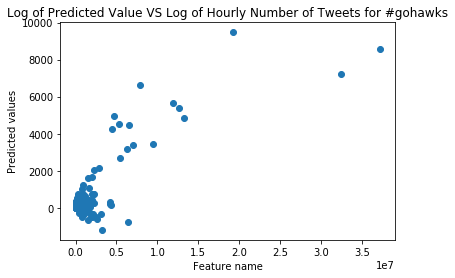

Hashtag: gopatriots


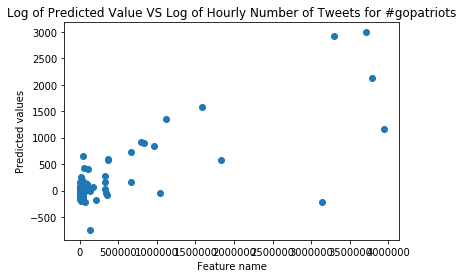

Hashtag: nfl


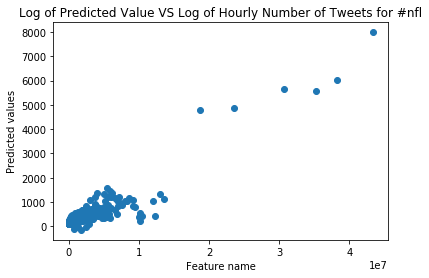

Hashtag: patriots


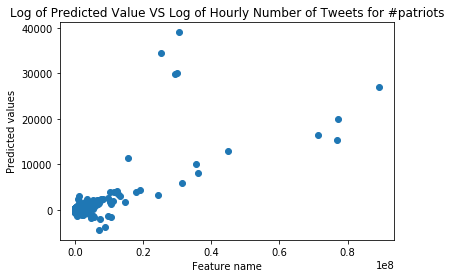

Hashtag: sb49


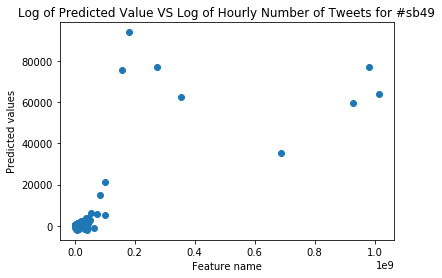

Hashtag: superbowl


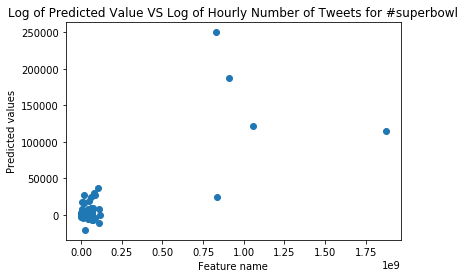

In [78]:
# Plotting

for tagg in hashtags:
    y = data_hashtag_all[tagg][1:,0] # Number of tweets (except first)
    X = np.delete(data_hashtag_all[tagg], -1, 0) # Delete last row
    print('Hashtag: '+ tagg)
    model = LinearRegression()
    mse_train , mse_test, predicted, X = analyze_lr_pred(model, X, y)
    plt.figure
    plt.scatter(X[:,2], predicted)
    plt.xlabel('Feature name')
    plt.ylabel('Predicted values')
    plt.title('Log of Predicted Value VS Log of Hourly Number of Tweets for #' + str(tagg))
    plt.show()